In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error

## NN
from keras.models import Sequential
from keras.layers import Dense

In [2]:
irl =  pd.read_csv('sub-dub-encoded.csv', index_col = 'Unnamed: 0')

In [3]:
irl.head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
207901,0,1,2014,1,601864.418417,0,899721.0,628715.337138,53.307878,-6.335665,7.541595,0.492120,1.438826,0.156609,13.648757
207905,1,0,2014,1,651335.338306,0,1661424.0,651335.338306,53.288227,-6.238896,6.817210,0.100996,2.784711,0.831639,13.532203
207916,0,1,2014,1,741771.837018,1,597863.0,628715.337138,53.291600,-6.312400,7.799393,0.683556,3.098765,0.968202,12.824045
207925,1,1,2014,1,414681.974545,0,334587.0,406163.221538,53.353853,-6.372213,8.400802,0.319564,1.909348,0.262801,12.099628
207929,1,2,2014,1,570683.081926,1,305308.0,411979.725512,53.366311,-6.263792,2.225835,0.085034,0.909828,0.597393,12.569631


In [4]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

## 2021

In [5]:
specific21 = irl[irl['Year'] > 2017]
train_21 = specific21[specific21['Year'] < 2021]
test_21 = specific21[specific21['Year'] == 2021]

x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [6]:
# Defining a function to find the best parameters for ANN
from sklearn.metrics import mean_absolute_percentage_error
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData = pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber += 1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units = 5, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer = 'normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer = 'adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
        
            y_predicted_21 = model.predict(X_test)
 
            MAPE = mean_absolute_percentage_error(y_test, y_predicted_21)
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100 - MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 

##### Calling the function
ResultsData = FunctionFindBestParams(x_train_21, y_train_21, x_test_21, y_test_21)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 99.77022458719247
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 99.78992057363709
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 99.95789770546781
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 99.97699884842007
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 99.71617577244159
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 99.86599291621599
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 99.9595161856939
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 99.96287976046563
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 99.7110228080643
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 99.62351254795271
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 99.53102991774408
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 99.97498763081644
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 99.79345044875967
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 99.75923090118162
15 Parameters: batch_s

<AxesSubplot:xlabel='Parameters'>

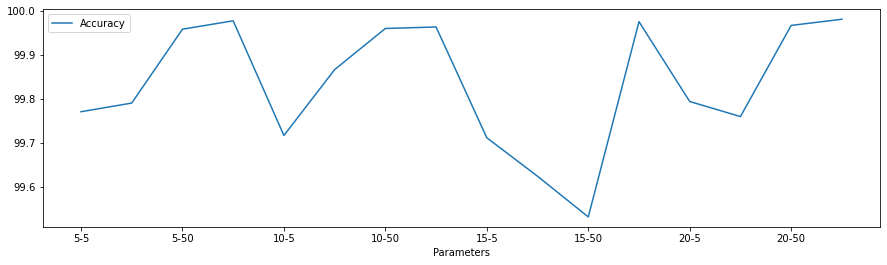

In [7]:
%matplotlib inline
ResultsData.plot(x = 'Parameters', y = 'Accuracy', figsize = (15,4), kind = 'line')

In [8]:
# create ANN model
t = ResultsData.max()
lst = t['Parameters'].split('-')
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units = 5, input_dim = x_train_21.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model.fit(x_train_21, y_train_21, batch_size = int(lst[0]), epochs = int(lst[1]), verbose = 0)

In [9]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for NN 2021 is: ' + str(mse))

MSE for NN 2021 is: 0.1823468060606309


In [10]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared = False)
print('RMSE for NN 2021 is: ' + str(rmse))

RMSE for NN 2021 is: 0.4270208496790653


In [11]:
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for NN 2021 is: " + str(mape))

MAPE for NN 2021 is: 0.02275565099230949


In [12]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print("Accuracy for NN on 2021 data is: " + str(acc))

Accuracy for NN on 2021 data is: 0.27580372250423013


In [13]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'NN',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [14]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

## 2020

In [15]:
specific20 = irl[irl['Year'] > 2016]
train_20 = specific20[specific20['Year'] < 2020]
test_20 = specific20[specific20['Year'] == 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 99.77891802243958
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 99.79522545825576
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 99.97675912480746
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 99.98499386277075
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 99.10568113924218
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 99.75718275551434
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 99.98360743099131
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 99.97883528649957
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 99.70797705695966
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 99.05124402263347
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 99.93717459491957
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 99.88660523871289
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 99.75653988259118
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 99.69130870230971
15 Parameters: batch

<AxesSubplot:xlabel='Parameters'>

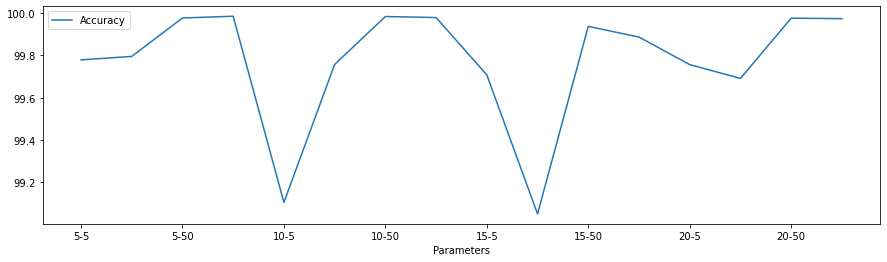

In [16]:
ResultsData1 = FunctionFindBestParams(x_train_20, y_train_20, x_test_20, y_test_20)
ResultsData1.plot(x = 'Parameters', y = 'Accuracy', figsize = (15,4), kind = 'line')

In [17]:
# create ANN model
t = ResultsData1.max()
lst = t['Parameters'].split('-')
model1 = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model1.add(Dense(units = 5, input_dim = x_train_20.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model1.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model1.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model1.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model1.fit(x_train_20, y_train_20, batch_size = int(lst[0]), epochs = int(lst[1]), verbose = 0)

In [18]:
y_predicted_20 = model1.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_predicted_20)
print('MSE for NN 2020 is: ' + str(mse))

MSE for NN 2020 is: 0.17102317581950952


In [19]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared = False)
print('RMSE for NN 2020 is: ' + str(rmse))

RMSE for NN 2020 is: 0.41354948412434217


In [20]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for NN 2020 is: " + str(mape))

MAPE for NN 2020 is: 0.022949642640744287


In [21]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print("Accuracy for NN on 2020 data is: " + str(acc))

Accuracy for NN on 2020 data is: 0.2886762360446571


In [22]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'NN',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [23]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

## 2019

In [24]:
specific19 = irl[irl['Year'] > 2015]
train_19 = specific19[specific19['Year'] < 2019]
test_19 = specific19[specific19['Year'] == 2019]

x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']

x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 99.51902204455864
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 99.9845491718794
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 99.96627173515708
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 99.98199026800016
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 99.71100393839416
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 99.89257070600682
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 99.95880402403054
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 99.97556438083589
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 99.81347623410224
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 99.92444783674323
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 99.96442670325186
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 99.9707339504157
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 99.79271594742805
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 99.06245365093974
15 Parameters: batch_s

<AxesSubplot:xlabel='Parameters'>

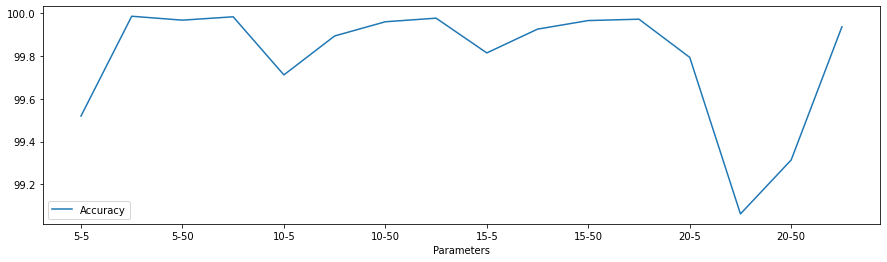

In [25]:
ResultsData2 = FunctionFindBestParams(x_train_19, y_train_19, x_test_19, y_test_19)
ResultsData2.plot(x = 'Parameters', y = 'Accuracy', figsize = (15,4), kind = 'line')

In [26]:
t = ResultsData2.max()
lst2 = t['Parameters'].split('-')

# create ANN model
model2 = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model2.add(Dense(units = 5, input_dim = x_train_19.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model2.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model2.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model2.fit(x_train_19, y_train_19, batch_size = int(lst2[0]), epochs = int(lst2[1]), verbose = 0)

In [27]:
y_predicted_19 = model2.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_predicted_19)
print('MSE for NN 2019 is: ' + str(mse))

MSE for NN 2019 is: 0.1243036426147496


In [28]:
rmse = mean_squared_error(y_test_19, y_predicted_19, squared = False)
print('RMSE for NN 2019 is: ' + str(rmse))

RMSE for NN 2019 is: 0.35256721715830247


In [29]:
mape = mean_absolute_percentage_error(y_test_19, y_predicted_19)
print("MAPE for NN 2019 is: " + str(mape))

MAPE for NN 2019 is: 0.018189002758996726


In [30]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)
print("Accuracy for NN on 2019 data is: " + str(acc))

Accuracy for NN on 2019 data is: 0.36180904522613067


In [31]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns=cnames)

df13 = df13.append({'Algorithm': 'NN',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [32]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

## 2018

In [33]:
specific18 = irl[irl['Year'] > 2014]
train_18 = specific18[specific18['Year'] < 2018]
test_18 = specific18[specific18['Year'] == 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']

x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 99.77995217201587
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 99.97293505634195
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 99.96675700015153
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 99.95427030864535
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 99.64494407447823
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 99.87840202869963
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 99.59662918006154
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 99.9839757845473
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 99.52997091184491
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 99.64310286012666
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 99.76343137379305
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 99.96731430358203
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 99.70386664914065
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 99.04037154708953
15 Parameters: batch_

<AxesSubplot:xlabel='Parameters'>

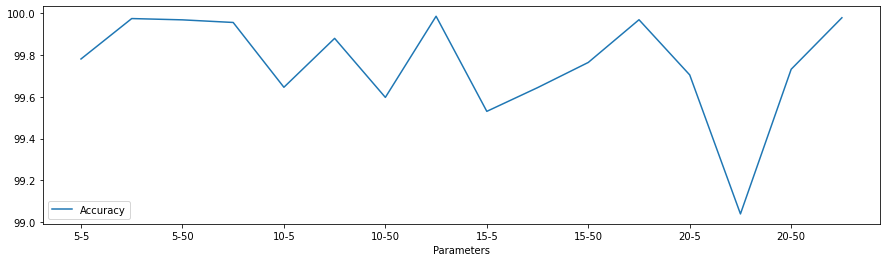

In [34]:
ResultsData3 = FunctionFindBestParams(x_train_18, y_train_18, x_test_18, y_test_18)
ResultsData3.plot(x = 'Parameters', y = 'Accuracy', figsize = (15,4), kind = 'line')

In [35]:
t = ResultsData3.max()
lst2 = t['Parameters'].split('-')

# create ANN model
model2 = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model2.add(Dense(units = 5, input_dim = x_train_18.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model2.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model2.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model2.fit(x_train_18, y_train_18, batch_size = int(lst2[0]), epochs = int(lst2[1]), verbose = 0)

In [36]:
y_predicted_18 = model2.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_predicted_18)
print('MSE for NN 2018 is: ' + str(mse))

MSE for NN 2018 is: 0.23880581652385477


In [37]:
rmse = mean_squared_error(y_test_18, y_predicted_18, squared = False)
print('RMSE for NN 2018 is: ' + str(rmse))

RMSE for NN 2018 is: 0.488677620240435


In [38]:
mape = mean_absolute_percentage_error(y_test_18, y_predicted_18)
print("MAPE for NN 2018 is: " + str(mape))

MAPE for NN 2018 is: 0.026910487370823848


In [39]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)
print("Accuracy for NN on 2018 data is: " + str(acc))

Accuracy for NN on 2018 data is: 0.28019925280199254


In [40]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'NN',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [41]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

## Results & Evaluation

In [50]:
vis1 = pd.concat([df11, df12, df13, df14], ignore_index=True)

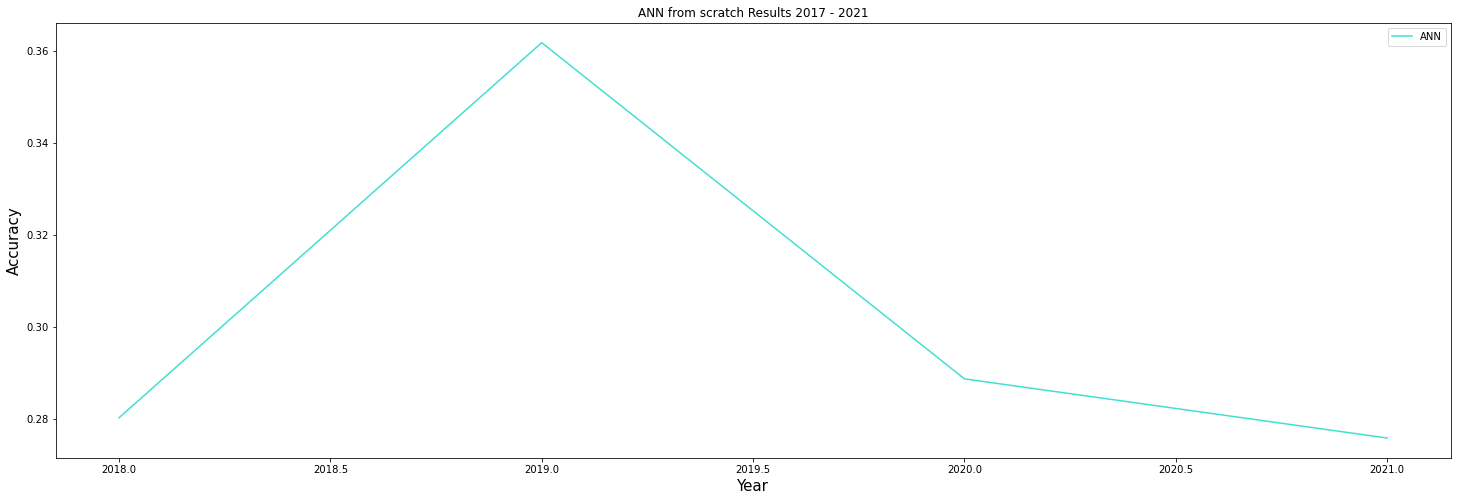

In [51]:
## had to leave 2017 out due to strange error
plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], label = 'ANN', color = 'turquoise')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('ANN from scratch Results 2017 - 2021')
plt.legend()
plt.show()

In [52]:
print("Mean accuracy for ANN over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))

Mean accuracy for ANN over period 2017-2021 is: 0.30162206414425263


In [53]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)

pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)

In [54]:
actualvpred = actual.join(pred)
actualvpred.head()

,Actual,Predicted
0,12.716376,12.896753
1,12.838977,12.896753
2,13.164398,12.896753
3,12.888984,12.896753
4,12.744948,12.896753


In [55]:
exp = np.exp(actualvpred)

In [56]:
exp.shape

(2817, 2)

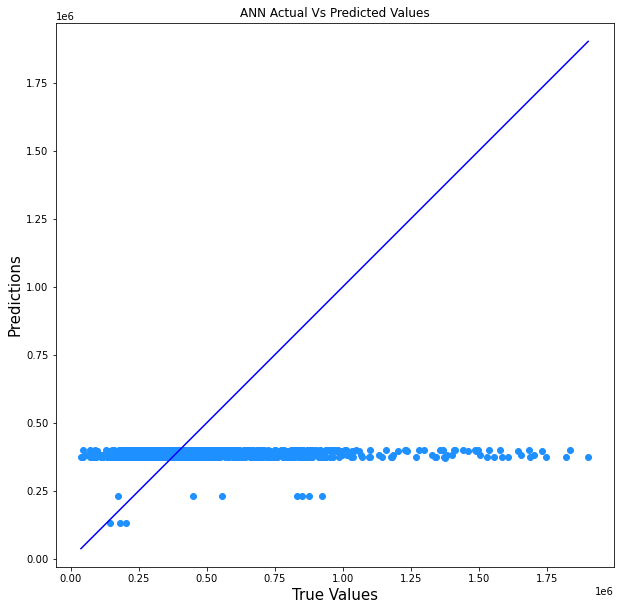

In [57]:
# plot predicted vs actual
## this is using actual prices
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'dodgerblue')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('ANN Actual Vs Predicted Values')
plt.axis('equal')
plt.show()

## Opinions on these Results

Overall, these results are very poor. Even with more layers and testing out of more hyperparameter tuning it is unlikely in the extreme that our results would make up the necessary ~30% on our best performing model (TPOT AutoML). We will not be trying this going forward with other cities as it is clear these results are of such a poor quality. Even still the AutoML libraries we are utilising contain NN / ANN libraries in them and they are never the best fit for our data. It is quite common that deep learning models struggle with smaller datasets like so and are more suited for larger datasets.